## Load Data

In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
sc.master

'local[*]'

In [3]:
# Create a SparkSession with legacy time parser policy
spark = SparkSession.builder \
    .appName("YourAppName") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

24/05/21 17:21:05 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [36]:
from pyspark.sql.types import *
import pyspark
import time
from pyspark.sql.functions import max
from pyspark.sql.functions import split
from pyspark.sql.functions import size
from pyspark.sql.functions import from_utc_timestamp
from pyspark.sql.functions import date_format
from pyspark.sql.functions import from_unixtime
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import trim
from pyspark.sql.functions import lower
from pyspark.sql.functions import count
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import col
from pyspark.sql.functions import regexp_replace, col, lower, trim, concat_ws
from pyspark.ml.feature import Tokenizer, StopWordsRemover
import matplotlib.pyplot as plt

import warnings
# Suppress warnings
warnings.filterwarnings("ignore")
import logging
# Suppress WARN messages
log = logging.getLogger('py4j')
log.setLevel(logging.ERROR)

In [5]:
df = spark.read.csv("hdfs://localhost:9000/user1/ProjectTweets.csv", header=False, inferSchema=True)

# Show the first few rows of the DataFrame
df.show(5)

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+---+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



## Exploration

In [6]:
df.count()

1600000

In [7]:
# Rename the columns
df = df.withColumnRenamed("_c0", "ID") \
       .withColumnRenamed("_c1", "ids") \
       .withColumnRenamed("_c2", "date") \
       .withColumnRenamed("_c3", "flag") \
       .withColumnRenamed("_c4", "user") \
       .withColumnRenamed("_c5", "text")

# Display the DataFrame schema to verify the changes and show the first few rows
df.printSchema()
df.show()

root
 |-- ID: integer (nullable = true)
 |-- ids: long (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)

+---+----------+--------------------+--------+---------------+--------------------+
| ID|       ids|                date|    flag|           user|                text|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  6|1467811592|Mon Apr 06

In [8]:
df.select("date").first()[0]

'Mon Apr 06 22:19:45 PDT 2009'

In [9]:
# Select only the 'ID', 'date', and 'text' columns
df = df.select("ID", "ids", "date", "text")

# Calculate the maximum number of words in the 'text' field
max_words = df.withColumn("word_count", size(split(df.text, " "))) \
              .agg(max("word_count")).first()[0]

# Display the maximum number of words in the 'text' field
print(f"The maximum number of words in the 'text' field is: {max_words}")

The maximum number of words in the 'text' field is: 110


In [10]:
current_format = "EEE MMM dd HH:mm:ss zzz yyyy"

# Convert and reformat the date column
df = df.withColumn("formatted_date", date_format(
    from_utc_timestamp(
        from_unixtime(unix_timestamp(col("date"), "EEE MMM dd HH:mm:ss zzz yyyy")), "PST"),"yyyy-MM-dd"))

# Convert to timestamp while considering time zone
df = df.withColumn("timestamp", 
                   from_utc_timestamp(unix_timestamp(col("date"), current_format).cast("timestamp"), "PST"))

# Create a new column that extracts just the day of the week (e.g., 'Mon')
df = df.withColumn("day_of_week", date_format("timestamp", "EEE"))

# Show results
df.show(5)

+---+----------+--------------------+--------------------+--------------+-------------------+-----------+
| ID|       ids|                date|                text|formatted_date|          timestamp|day_of_week|
+---+----------+--------------------+--------------------+--------------+-------------------+-----------+
|  0|1467810369|Mon Apr 06 22:19:...|@switchfoot http:...|    2009-04-06|2009-04-06 23:19:45|        Mon|
|  1|1467810672|Mon Apr 06 22:19:...|is upset that he ...|    2009-04-06|2009-04-06 23:19:49|        Mon|
|  2|1467810917|Mon Apr 06 22:19:...|@Kenichan I dived...|    2009-04-06|2009-04-06 23:19:53|        Mon|
|  3|1467811184|Mon Apr 06 22:19:...|my whole body fee...|    2009-04-06|2009-04-06 23:19:57|        Mon|
|  4|1467811193|Mon Apr 06 22:19:...|@nationwideclass ...|    2009-04-06|2009-04-06 23:19:57|        Mon|
+---+----------+--------------------+--------------------+--------------+-------------------+-----------+
only showing top 5 rows



In [12]:
# Count missing values in the 'date' column
df.filter(col("formatted_date").isNull()).count()

0

In [13]:
# Remove duplicates based on the 'ids' column
df = df.dropDuplicates(["ids"])
df.count()

1598315

In [43]:
from pyspark.sql.functions import desc, lower, trim, regexp_replace

# Standardize the hashtag column by converting to lowercase and removing extra spaces and punctuation
cleaned_hashtags_df = hashtags_df.withColumn("clean_hashtag", lower(trim(regexp_replace(hashtags_df["hashtag"], "[^\w\s]", ""))))

# Group by 'clean_hashtag' column and count occurrences, then order by count in descending order
most_frequent_hashtags = cleaned_hashtags_df.groupBy("clean_hashtag").count().orderBy(desc("count")).limit(30)

# Show the most frequent hashtags
most_frequent_hashtags.show(truncate=False)

+-------------+-----+
|clean_hashtag|count|
+-------------+-----+
|followfriday |2626 |
|fb           |1768 |
|ff           |980  |
|squarespace  |934  |
|             |709  |
|iranelection |513  |
|1            |500  |
|seb          |499  |
|musicmonday  |415  |
|fail         |362  |
|asot400      |324  |
|2            |318  |
|iphone       |315  |
|iremember    |297  |
|bsb          |296  |
|myweakness   |269  |
|marsiscoming |259  |
|f1           |258  |
|e3           |254  |
|bgt          |245  |
+-------------+-----+
only showing top 20 rows



In [25]:
# Define a function to clean the text
def clean_text(df, text_col):
    # Remove URLs
    df = df.withColumn(text_col, regexp_replace(col(text_col), 'http\S+|www.\S+', ''))
    # Remove special characters
    df = df.withColumn(text_col, regexp_replace(col(text_col), '[^a-zA-Z\s]', ''))
    # Convert to lowercase
    df = df.withColumn(text_col, lower(col(text_col)))
    # Trim whitespace
    df = df.withColumn(text_col, trim(col(text_col)))
    return df

# Apply the clean_text function
df_cleaned = clean_text(df, 'text')

# Tokenize the cleaned text
tokenizer = Tokenizer(inputCol='text', outputCol='words')
df_tokenized = tokenizer.transform(df_cleaned)

# Remove stop words
remover = StopWordsRemover(inputCol='words', outputCol='filtered_words')
df_preprocessed = remover.transform(df_tokenized)

# Convert the array of words into a string
df_preprocessed = df_preprocessed.withColumn('filtered_words_str', concat_ws(' ', col('filtered_words')))



In [32]:
# Select necessary columns from the initial dataframe and the preprocessed columns
df_final = df_preprocessed.select('formatted_date', 'timestamp', 'text', 'filtered_words_str')
df_final.show(5)

+--------------+-------------------+--------------------+--------------------+
|formatted_date|          timestamp|                text|  filtered_words_str|
+--------------+-------------------+--------------------+--------------------+
|    2009-04-06|2009-04-06 23:20:05|tatianak nope the...| tatianak nope didnt|
|    2009-04-06|2009-04-06 23:20:20|iamjazzyfizzle i ...|iamjazzyfizzle wi...|
|    2009-04-06|2009-04-06 23:20:34|fakerpattypattz o...|fakerpattypattz o...|
|    2009-04-06|2009-04-06 23:20:37|alydesigns i was ...|alydesigns day di...|
|    2009-04-06|2009-04-06 23:20:40|angrybarista i ba...|angrybarista bake...|
+--------------+-------------------+--------------------+--------------------+
only showing top 5 rows



In [30]:
df_single_partition = df_final.repartition(1)

df_single_partition.write.csv("hdfs://localhost:9000/user1/ProcessedTweet.csv", header=True)

In [32]:
df = df.drop("text")

In [34]:
# Count the number of distinct IDs for each 'formatted_date' and 'day_of_week'
distinct_id_count = df.groupBy("formatted_date", "day_of_week").agg(countDistinct("ID").alias("count_of_IDs"))

# Sort the data by 'formatted_date'
sorted_data = distinct_id_count.orderBy("formatted_date")

# Show all the results
sorted_data.show(sorted_data.count(), truncate=False)

+--------------+-----------+------------+
|formatted_date|day_of_week|count_of_IDs|
+--------------+-----------+------------+
|2009-04-06    |Mon        |1351        |
|2009-04-07    |Tue        |19292       |
|2009-04-17    |Fri        |3083        |
|2009-04-18    |Sat        |19732       |
|2009-04-19    |Sun        |27415       |
|2009-04-20    |Mon        |18478       |
|2009-04-21    |Tue        |10552       |
|2009-05-01    |Fri        |5722        |
|2009-05-02    |Sat        |27492       |
|2009-05-03    |Sun        |35167       |
|2009-05-04    |Mon        |17474       |
|2009-05-09    |Sat        |9755        |
|2009-05-10    |Sun        |27961       |
|2009-05-11    |Mon        |2840        |
|2009-05-12    |Tue        |1344        |
|2009-05-13    |Wed        |2154        |
|2009-05-14    |Thu        |19340       |
|2009-05-16    |Sat        |7204        |
|2009-05-17    |Sun        |38181       |
|2009-05-18    |Mon        |40271       |
|2009-05-22    |Fri        |41146 

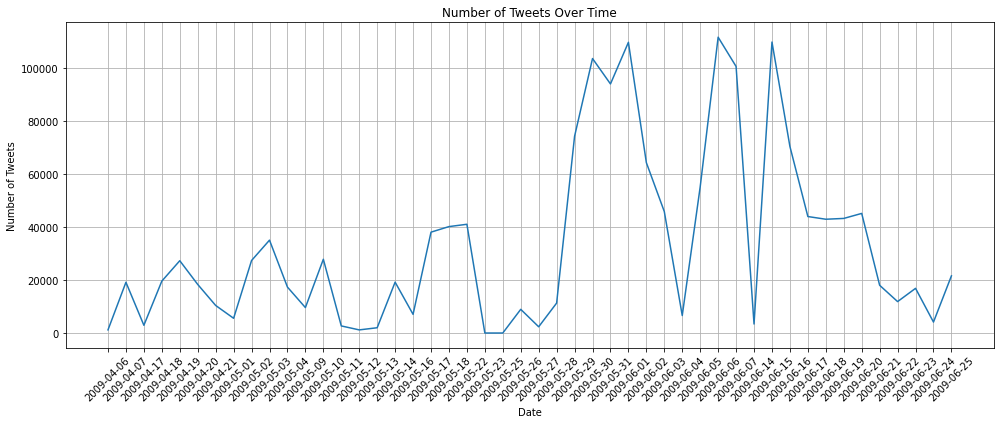

In [38]:
# Extracting data for plotting
dates = sorted_data.select("formatted_date").rdd.flatMap(lambda x: x).collect()
counts = sorted_data.select("count_of_IDs").rdd.flatMap(lambda x: x).collect()

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(dates, counts, linestyle='-')
plt.title("Number of Tweets Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
from pyspark.sql.functions import desc, lower, trim, regexp_replace

# Standardize the text column by converting to lowercase and removing extra spaces and punctuation
cleaned_df = df.withColumn("clean_text", lower(trim(regexp_replace(df["text"], "[^\w\s]", ""))))

# Group by 'clean_text' column and count occurrences, then order by count in descending order
most_frequent_tweets = cleaned_df.groupBy("clean_text").count().orderBy(desc("count")).limit(20)

# Show the first 20 most frequent tweets
most_frequent_tweets.show(truncate=False)

24/05/22 07:53:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/22 07:53:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/22 07:53:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/22 07:53:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-----------------------+-----+
|clean_text             |count|
+-----------------------+-----+
|good morning           |476  |
|headache               |289  |
|goodnight              |257  |
|happy mothers day      |231  |
|my tummy hurts         |212  |
|isplayer has died sorry|210  |
|at work                |185  |
|its raining            |158  |
|good morning everyone  |141  |
|my head hurts          |128  |
|back to work           |121  |
|homework               |119  |
|off to work            |119  |
|just woke up           |112  |
|i have a headache      |112  |
|so tired               |109  |
|i miss you             |106  |
|i dont feel good       |90   |
|getting ready for work |90   |
|nothing                |88   |
+-----------------------+-----+



In [16]:
# Count the number of distinct IDs for each 'formatted_date'
distinct_id_count = df.groupBy("formatted_date").agg(countDistinct("ID").alias("count_of_IDs"))

# Sort the data by 'formatted_date'
sorted_data = distinct_id_count.orderBy("formatted_date")

# Show the results
sorted_data.show(sorted_data.count(), truncate=False)

+--------------+------------+
|formatted_date|count_of_IDs|
+--------------+------------+
|2009-04-06    |1351        |
|2009-04-07    |19292       |
|2009-04-17    |3083        |
|2009-04-18    |19732       |
|2009-04-19    |27415       |
|2009-04-20    |18478       |
|2009-04-21    |10552       |
|2009-05-01    |5722        |
|2009-05-02    |27492       |
|2009-05-03    |35167       |
|2009-05-04    |17474       |
|2009-05-09    |9755        |
|2009-05-10    |27961       |
|2009-05-11    |2840        |
|2009-05-12    |1344        |
|2009-05-13    |2154        |
|2009-05-14    |19340       |
|2009-05-16    |7204        |
|2009-05-17    |38181       |
|2009-05-18    |40271       |
|2009-05-22    |41146       |
|2009-05-23    |169         |
|2009-05-25    |169         |
|2009-05-26    |9092        |
|2009-05-27    |2517        |
|2009-05-28    |11455       |
|2009-05-29    |74301       |
|2009-05-30    |103606      |
|2009-05-31    |94030       |
|2009-06-01    |109721      |
|2009-06-0

In [17]:
# Calculate the total number of IDs (including duplicates) for each 'formatted_date'
total_id_count = df.groupBy("formatted_date").agg(count("ID").alias("total_id_count"))

# Find the maximum of 'total_id_count' across all days
max_total_id_count = total_id_count.agg(max("total_id_count").alias("max_total_id_count"))

# Show the maximum number of IDs
max_total_id_count.show()

+------------------+
|max_total_id_count|
+------------------+
|            111649|
+------------------+



In [18]:
# Count the number of distinct 'formatted_date' entries
distinct_days_count = df.select(countDistinct("formatted_date").alias("distinct_days_count"))

# Show the number of distinct days
distinct_days_count.show()

+-------------------+
|distinct_days_count|
+-------------------+
|                 48|
+-------------------+



In [19]:
df_single_partition = df.repartition(1)

df_single_partition.write.csv("hdfs://localhost:9000/user1/PrepTweets.csv", header=True, mode="overwrite")


In [18]:
# Write DataFrame to MongoDB
df.write.format("com.mongodb.spark.sql.DefaultSource"
               ).option("spark.mongodb.output.uri","mongodb://localhost:27017/Tweets_db.my_collection"
                       ).mode("overwrite").save()